In [2]:
# Import the libraries

import pandas as pd 
import numpy as np

from pprint import pprint

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import spacy

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings("ignore")


/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


Code references:

https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/


In [3]:
df = pd.read_csv('sentiment-document-level.csv')

In [4]:
df.head()

,Unnamed: 0,date,review,rating,status,length,label,language_score,language,scores,compound,sentiment
0,0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,"{'language': 'en', 'score': 0.9999952554167907}",en,"{'neg': 0.0, 'neu': 0.601, 'pos': 0.399, 'comp...",0.9062,pos
1,1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,"{'language': 'en', 'score': 0.9999965355369269}",en,"{'neg': 0.0, 'neu': 0.453, 'pos': 0.547, 'comp...",0.9678,pos
2,2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,"{'language': 'en', 'score': 0.9999969728448782}",en,"{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...",0.4703,pos
3,3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,"{'language': 'en', 'score': 0.9999975171629499}",en,"{'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'comp...",0.9448,pos
4,4,2021-03-11,Perfect for new learners,5,completer,24,pos,"{'language': 'en', 'score': 0.9999971873771439}",en,"{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp...",0.5719,pos


In [5]:
df.drop(['Unnamed: 0', 'date', 'language_score', 'language', 'scores'], axis = 1, inplace = True)

In [6]:
df

,review,rating,status,length,label,compound,sentiment
0,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,0.9062,pos
1,Super easy and totally for the beginners like ...,5,completer,163,pos,0.9678,pos
2,Very interactive and a nice course to start pr...,5,completer,67,pos,0.4703,pos
3,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,0.9448,pos
4,Perfect for new learners,5,completer,24,pos,0.5719,pos
...,...,...,...,...,...,...,...
9686,excellent explanation starting with how comput...,5,dropout,129,pos,0.9080,pos
9687,My friend recommanded the lecture. It really d...,5,dropout,69,pos,0.5411,pos
9688,Highly recommend this sets a good foundation ...,5,dropout,56,pos,0.6901,pos
9689,best python programming course for absolute be...,5,dropout,53,pos,0.6369,pos


In [7]:
# Check for null values

len(df[df['review'].isna()==True])

0

In [8]:
# Drop null values

# df.dropna(inplace = True)

In [9]:
# Check for null values

# len(df[df['review'].isna()==True])

In [10]:
# Reset the index

# df = df.reset_index(drop = True)

In [11]:
df

,review,rating,status,length,label,compound,sentiment
0,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,0.9062,pos
1,Super easy and totally for the beginners like ...,5,completer,163,pos,0.9678,pos
2,Very interactive and a nice course to start pr...,5,completer,67,pos,0.4703,pos
3,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,0.9448,pos
4,Perfect for new learners,5,completer,24,pos,0.5719,pos
...,...,...,...,...,...,...,...
9686,excellent explanation starting with how comput...,5,dropout,129,pos,0.9080,pos
9687,My friend recommanded the lecture. It really d...,5,dropout,69,pos,0.5411,pos
9688,Highly recommend this sets a good foundation ...,5,dropout,56,pos,0.6901,pos
9689,best python programming course for absolute be...,5,dropout,53,pos,0.6369,pos


In [12]:
# Define a function to plot the most frequent words

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 45)
    plt.show()

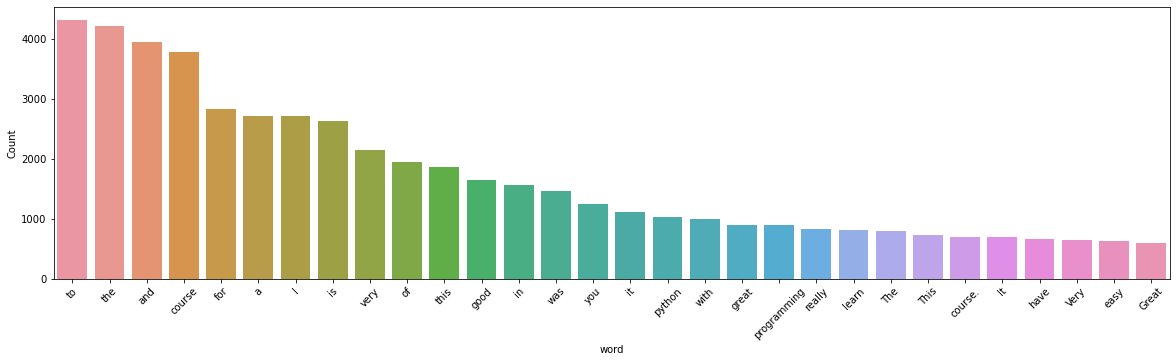

In [13]:
# The most frquent words are stop words such as 'to' and 'the' we will remove these in the preprocessing steps

freq_words(df['review'])

## Preprocessing

In [14]:
# Covert to lowercase

df['preprocessed'] =  df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['preprocessed'].head()

0    nice course for beginners where we can enjoy a...
1    super easy and totally for the beginners like ...
2    very interactive and a nice course to start pr...
3    awesome course! definitely a very nice introdu...
4                             perfect for new learners
Name: preprocessed, dtype: object

In [15]:
# Remove punctuations

df['preprocessed'] = df['preprocessed'].str.replace('[^\w\s]','')
df['preprocessed'].head()

0    nice course for beginners where we can enjoy a...
1    super easy and totally for the beginners like ...
2    very interactive and a nice course to start pr...
3    awesome course definitely a very nice introduc...
4                             perfect for new learners
Name: preprocessed, dtype: object

In [16]:
# Remove stopwords

stop = stopwords.words('english')
stop.extend(['good', 'great', 'really', 'like', 'nice'])

df['preprocessed'] = df['preprocessed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['preprocessed'].head()

0    course beginners enjoy learn well dr chuck mad...
1    super easy totally beginners course title prof...
2          interactive course start programming pyhton
3    awesome course definitely introduction coding ...
4                                 perfect new learners
Name: preprocessed, dtype: object

In [17]:
# Remove short words (length < 3)

# df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# df['review'].head()

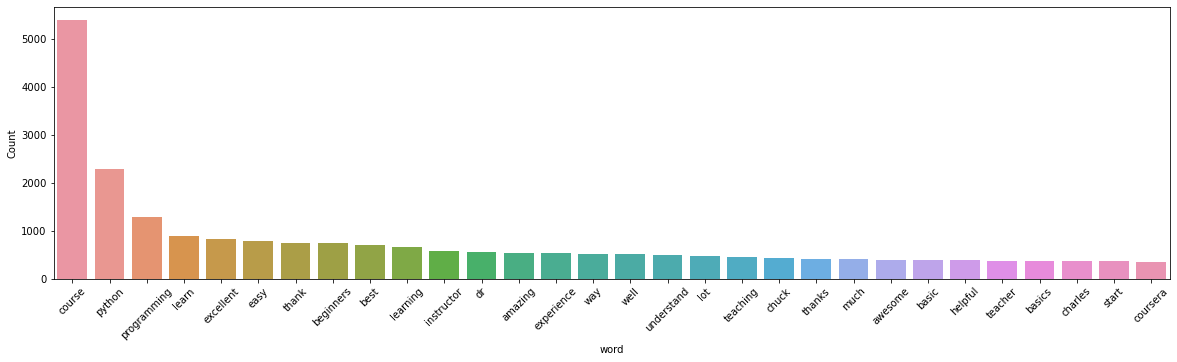

In [18]:
# Look at the most frequent words again 

freq_words(df['preprocessed'])

In [19]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')

df['preprocessed'] = df['preprocessed'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['preprocessed'].head(5)


0    [course, beginners, enjoy, learn, well, dr, ch...
1    [super, easy, totally, beginners, course, titl...
2    [interactive, course, start, programming, pyhton]
3    [awesome, course, definitely, introduction, co...
4                             [perfect, new, learners]
Name: preprocessed, dtype: object

In [20]:
# Add speech tags

df['preprocessed'] = df['preprocessed'].apply(nltk.tag.pos_tag)
df['preprocessed'].head()

0    [(course, NN), (beginners, NNS), (enjoy, VBP),...
1    [(super, JJ), (easy, JJ), (totally, RB), (begi...
2    [(interactive, JJ), (course, NN), (start, NN),...
3    [(awesome, JJ), (course, NN), (definitely, RB)...
4          [(perfect, JJ), (new, JJ), (learners, NNS)]
Name: preprocessed, dtype: object

In [21]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [22]:
# Apply the function to the tagged data

df['preprocessed'] = df['preprocessed'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df['preprocessed'].head()

0    [(course, n), (beginners, n), (enjoy, v), (lea...
1    [(super, a), (easy, a), (totally, r), (beginne...
2    [(interactive, a), (course, n), (start, n), (p...
3    [(awesome, a), (course, n), (definitely, r), (...
4              [(perfect, a), (new, a), (learners, n)]
Name: preprocessed, dtype: object

In [23]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

df['preprocessed'] = df['preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
df['preprocessed'].head()

0    [course, beginner, enjoy, learn, well, dr, chu...
1    [super, easy, totally, beginner, course, title...
2        [interactive, course, start, program, pyhton]
3    [awesome, course, definitely, introduction, co...
4                              [perfect, new, learner]
Name: preprocessed, dtype: object

In [24]:
# Join reviews

df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

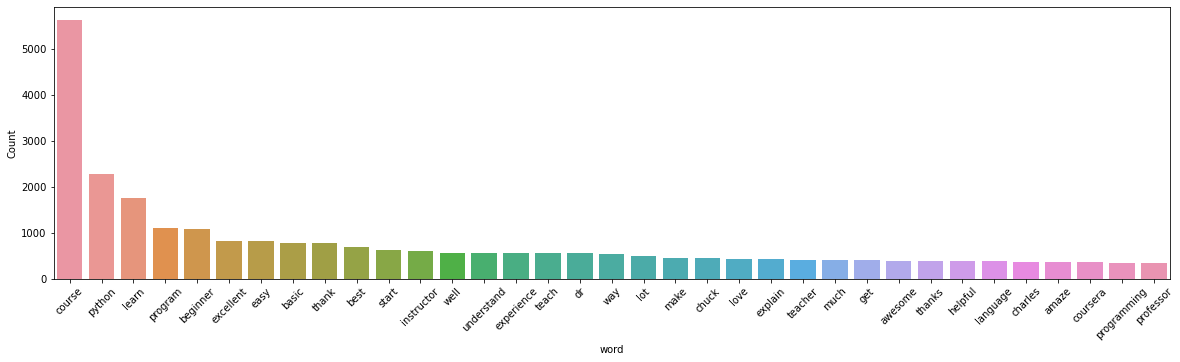

In [25]:
# Most frequent words after lemmatizing 

freq_words(df['joined'], 35)

## LDA Topic Modeling

In [26]:
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(df['preprocessed'])

In [27]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 50 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [28]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

corpus = [dictionary.doc2bow(doc) for doc in df['preprocessed']]


In [47]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus = corpus, id2word = dictionary, num_topics = 5, random_state = 100,
                chunksize = 100, passes = 10)

In [48]:
# Explore the words occurring in each topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))

Topic: 0
Word: 0.073*"course" + 0.028*"make" + 0.028*"easy" + 0.024*"assignment" + 0.024*"instructor" + 0.023*"well" + 0.023*"explain" + 0.020*"way" + 0.018*"understand" + 0.017*"think"

Topic: 1
Word: 0.122*"learn" + 0.080*"course" + 0.071*"lot" + 0.061*"experience" + 0.060*"awesome" + 0.058*"teach" + 0.044*"way" + 0.037*"thanks" + 0.035*"thank" + 0.034*"python"

Topic: 2
Word: 0.107*"course" + 0.100*"python" + 0.073*"excellent" + 0.061*"basic" + 0.050*"program" + 0.043*"easy" + 0.037*"learn" + 0.032*"understand" + 0.030*"language" + 0.028*"programming"

Topic: 3
Word: 0.285*"course" + 0.089*"beginner" + 0.079*"best" + 0.073*"python" + 0.043*"love" + 0.035*"start" + 0.033*"amaze" + 0.030*"helpful" + 0.028*"one" + 0.028*"learn"

Topic: 4
Word: 0.067*"dr" + 0.062*"thank" + 0.059*"course" + 0.055*"chuck" + 0.036*"charles" + 0.032*"severance" + 0.031*"teacher" + 0.031*"coursera" + 0.026*"much" + 0.024*"program"



### Visualise with pyLDAvis

Original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [49]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.067821 -0.232541       1        1  24.879370
2     -0.163761  0.029120       2        1  23.796276
4      0.156061 -0.066770       3        1  18.447122
3     -0.161195  0.162199       4        1  17.871805
1      0.236716  0.107992       5        1  15.005427, topic_info=          Term         Freq        Total Category  logprob  loglift
3       course  5520.000000  5520.000000  Default  30.0000  30.0000
46        best   665.000000   665.000000  Default  29.0000  29.0000
56   excellent   821.000000   821.000000  Default  28.0000  28.0000
1     beginner  1040.000000  1040.000000  Default  27.0000  27.0000
4           dr   584.000000   584.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
8       python   240.907863  2214.760017   Topic5  -3.3785  -0.3217
84     charles    75.365062   384.956955   Topic5  -4.5406   0.2660
0        basic    77.381964   763.061193   Topic5  -4.5142  -0.3918
36     teacher    63.427606   414.781484   Topic5  -4.7130   0.0189
41  instructor    58.041400   642.549168   Topic5  -4.8018  -0.5075

[242 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
82        1  0.583649   also
82        2  0.211107   also
82        3  0.182132   also
82        5  0.024836   also
31        1  0.005560  amaze
...     ...       ...    ...
126       2  0.003897  would
126       3  0.498850  would
166       1  0.982231  write
49        3  0.459504   zero
49        4  0.533025   zero

[402 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 2])

What is topic perplexity and topic coherence: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [50]:
# Calculate Perplexity and Coherence

# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model = lda_model, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.76190190504247

Coherence Score:  0.5431910934889095


## Calculate the coherence score

Code reference: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [33]:
# Determine the optiomal number of topics by calculating the coherence score

# Define function for calculating coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus = corpus, num_topics = num_topics, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = corpus, texts = df['preprocessed'], start = 2, limit = 10, step = 1)

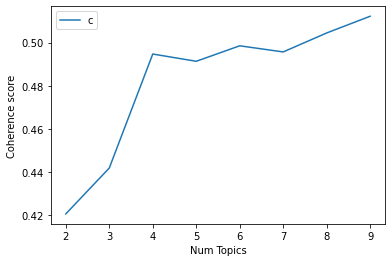

In [35]:
# Show graph

limit = 10; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()


In [36]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4207
Num Topics = 3  has Coherence Value of 0.4419
Num Topics = 4  has Coherence Value of 0.4947
Num Topics = 5  has Coherence Value of 0.4913
Num Topics = 6  has Coherence Value of 0.4985
Num Topics = 7  has Coherence Value of 0.4957
Num Topics = 8  has Coherence Value of 0.5045
Num Topics = 9  has Coherence Value of 0.5122


## LDA Mallet Model

Code reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [37]:
mallet_path = '/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 5, id2word = dictionary)

In [38]:
# Show Topics
pprint(ldamallet.show_topics(formatted = False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# The coherence score using the Mallet Model is lower than the original LDA Model

[(0,
  [('learn', 0.11059089441394898),
   ('teach', 0.08734258960284146),
   ('dr', 0.08685824991927672),
   ('lot', 0.08120762027768809),
   ('chuck', 0.07265095253471102),
   ('love', 0.07022925411688731),
   ('teacher', 0.06700032289312238),
   ('awesome', 0.06441717791411043),
   ('fun', 0.0487568614788505),
   ('amaze', 0.03293509848240232)]),
 (1,
  [('python', 0.1848585690515807),
   ('beginner', 0.178369384359401),
   ('learn', 0.15574043261231282),
   ('excellent', 0.13727121464226288),
   ('basic', 0.051580698835274545),
   ('clear', 0.03843594009983361),
   ('give', 0.03410981697171381),
   ('explanation', 0.03194675540765391),
   ('interesting', 0.022628951747088188),
   ('easily', 0.020632279534109815)]),
 (2,
  [('python', 0.18637083993660855),
   ('program', 0.1751188589540412),
   ('start', 0.09873217115689382),
   ('basic', 0.07321711568938194),
   ('language', 0.060063391442155306),
   ('programming', 0.05610142630744849),
   ('recommend', 0.05229793977812995),
   ('